# NF Analysis Workshop in Colab

## Demo Exercise 1: Tumor Deconvolution with Bulk RNA-seq Data

### 🧪 Biological context


![tme-figure](https://dr.clintile.com/fileJBYYJ/journal/article/dr/2023/1/2022-0024-01-1.jpg)

> Anjali Bhargav, Nishka Bhalla, Sneha Manoharan,  et al. Role of Various Immune Cells in the Tumor Microenvironment. Dis Res, 2023, 3(1): 30-40. Doi: 10.54457/DR.202301006

In cancer biology, the "tumor microenvironment" (TME) comprises the immune cells, extracellular matrix, blood vessels and various additional tissue-resident cell types that are part of the tumor ecosystem [^1]. Here we are interested in one important component, the composition of different immune cell types. However, there isn't always direct data from more cell assays like immunohistochemistry, flow cytometry, and mass cytometry for quantifying immune infiltrates. For the JHU Biobank, for example, only sequencing data is available.

Fortunately, RNA-seq data can be used to characterize TME through a number of computational approaches. One highly used "tumor deconvolution" method is CIBERSORT[^2], which is available programmatically through R and a Python implementation via the TumorDecon package[^3]. (Other approaches are helpfully reviewed and benchmarked in [^4] and [^5].)




[^1]: https://doi.org/10.1016/j.ccell.2023.02.016
[^2]: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5895181/
[^3]: https://doi.org/10.1016/j.softx.2022.101072
[^4]: https://academic.oup.com/bioinformatics/article/35/14/i436/5529146
[^5]: https://academic.oup.com/bib/article/22/4/bbaa219/5916936




### 📦 Install packages

1. Install `synapseclient` so that we can get data. Read more about the Python client here: https://python-docs.synapse.org/.
2. Install the analysis package `TumorDecon`.



In [ ]:
%pip install synapseclient TumorDecon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

### Get/prep data

> #### 🗒 NOTE
> Make sure you have set your `SYNAPSE_AUTH_TOKEN` (only View and Download permissions needed) in 🔑 Secrets before running the code block.

In [ ]:
import synapseclient
import TumorDecon as td
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import userdata

syn = synapseclient.Synapse()
syn.login(authToken = userdata.get('SYNAPSE_AUTH_TOKEN'))

Welcome, Anh Nguyet Vu!



INFO:synapseclient_default:Welcome, Anh Nguyet Vu!



We'll use the `quant.sf` files in the [processed RNA-seq dataset](https://www.synapse.org/#!Synapse:syn53140231.1/datasets/) and select which patients to include. This data contain the same information content as what's in cBioPortal, just not in matrix form, which is needed as the input. So we run a helper script to make the matrix after the files are downloaded.

Overall this demonstrates:
- How to query the metadata in the Synapse dataset to selectively download for your particular question/use case.
- Download the Synapse metadata and creating the clinical data.
- Downloading files in bulk.
- Wrangling data into another shape as needed (a common task).

Aside:
- We can also start at the [tsv dataset](https://www.synapse.org/#!Synapse:syn53141534/datasets/)  instead of the `quant.sf dataset` [quantsf dataset](https://www.synapse.org/#!Synapse:syn53140231/datasets), but the `quant.sf` can be more flexible, and during tutorial development it was suggested that starting at the `quant.sf` files *gives the added benefit of educating researchers who are less familiar with these outputs, since not everyone may be familiar with this genomics processing pipeline*.



#### Subsetting data with SQL-like query and downloading in bulk

This should be compared with selecting the files through the UI facets and transferring data via the UI component in the other part of the workshop.

Unlike with the UI, this does require basic SQL-like query. Query syntax can be referenced [here](https://rest-docs.synapse.org/rest/org/sagebionetworks/repo/web/controller/TableExamples.html). (Datasets are also tables.)

We will select by tumor type and where tissue is certain to by primary tumor (since there are a couple of patient-derived cell lines in the data). In the dataset, the options in the dataset are `quant.genes.sf` and `quant.sf`. They represent different levels of quantification.

`quant.sf`:
* Quantification results at the transcript level.
* Each row corresponds to a transcript, with columns providing details such as the transcript ID, length, effective length, number of reads (TPM), and estimated counts.
* Data in this file reflects the abundance of individual transcript isoforms.

`quant.genes.sf`:

* This file contains quantification results at the gene level.
* Each row corresponds to a gene, with columns similar to those in quant.sf but aggregated across all transcripts belonging to that gene.
* The data in this file represents the summed abundance of all transcript isoforms for each gene, providing a gene-level view of expression.

We need to select `quant.genes.sf` for our analysis because gene-level is what the package specifies. But `quant.sf` is useful for other types of analysis.

> #### TIP 💡
Files processed by NF-OSI will have a `workflowLink` attribute with the workflow docs where one can read more about the pipeline and outputs. Here one can see that the link is: https://nf-co.re/rnaseq/3.11.2/docs/output#star-and-salmon.

In [ ]:
dataset = "syn53140231"
tumor_types_of_interest = "('Plexiform Neurofibroma', 'Malignant Peripheral Nerve Sheath Tumor')"
results = syn.tableQuery(query = f"select * from {dataset} where tumorType in {tumor_types_of_interest} and tissue = 'primary tumor' and name = 'quant.genes.sf'",
                         includeRowIdAndRowVersion = False)
results = results.asDataFrame()
results

,id,name,tumorType,individualID,specimenID,createdOn,type,currentVersion,parentId,benefactorId,...,parentSpecimenID,resourceType,sex,species,specimenPreparationMethod,studyId,studyName,tissue,workflow,workflowLink
0,syn51538895,quant.genes.sf,Malignant Peripheral Nerve Sheath Tumor,JH-2-002,JH-2-002-94FAA,1684949982607,file,1,syn51537876,syn33397589,...,JH-2-002_MPNST_PT,experimentalData,Male,Homo sapiens,Flash frozen,syn4939902,The Johns Hopkins NF1 biospecimen repository,primary tumor,STAR and Salmon,https://nf-co.re/rnaseq/3.11.2/output#star-and...
1,syn51538907,quant.genes.sf,Malignant Peripheral Nerve Sheath Tumor,JH-2-023,JH-2-023-876HC,1684949984028,file,1,syn51537888,syn33397589,...,JH-2-023_MPNST_PT,experimentalData,Male,Homo sapiens,Flash frozen,syn4939902,The Johns Hopkins NF1 biospecimen repository,primary tumor,STAR and Salmon,https://nf-co.re/rnaseq/3.11.2/output#star-and...
2,syn51538984,quant.genes.sf,Malignant Peripheral Nerve Sheath Tumor,JH-2-031,JH-2-031-BFF3F,1684949989993,file,1,syn51537899,syn33397589,...,JH-2-031_MPNST_PT,experimentalData,Male,Homo sapiens,Flash frozen,syn4939902,The Johns Hopkins NF1 biospecimen repository,primary tumor,STAR and Salmon,https://nf-co.re/rnaseq/3.11.2/output#star-and...
3,syn51539631,quant.genes.sf,Plexiform Neurofibroma,JH-2-061,JH-2-061-1H66H,1684950028847,file,1,syn51537933,syn33397589,...,JH-2-061_PN_PT,experimentalData,Female,Homo sapiens,Flash frozen,syn4939902,The Johns Hopkins NF1 biospecimen repository,primary tumor,STAR and Salmon,https://nf-co.re/rnaseq/3.11.2/output#star-and...
4,syn51539636,quant.genes.sf,Plexiform Neurofibroma,JH-2-068,JH-2-068-2BHHG,1684950029243,file,1,syn51537945,syn33397589,...,JH-2-068_DifNF_PT_4,experimentalData,Male,Homo sapiens,Flash frozen,syn4939902,The Johns Hopkins NF1 biospecimen repository,primary tumor,STAR and Salmon,https://nf-co.re/rnaseq/3.11.2/output#star-and...
5,syn51539716,quant.genes.sf,Plexiform Neurofibroma,JH-2-075,JH-2-075-3HE68,1684950033104,file,1,syn51537958,syn33397589,...,JH-2-075_PN_PT,experimentalData,Male,NaN,Flash frozen,syn4939902,The Johns Hopkins NF1 biospecimen repository,primary tumor,STAR and Salmon,https://nf-co.re/rnaseq/3.11.2/output#star-and...
6,syn51540151,quant.genes.sf,Plexiform Neurofibroma,JH-2-002,JH-2-002-FF824,1684950058398,file,1,syn51537912,syn33397589,...,JH-2-002-b_PN_PT,experimentalData,Male,Homo sapiens,Flash frozen,syn4939902,The Johns Hopkins NF1 biospecimen repository,primary tumor,STAR and Salmon,https://nf-co.re/rnaseq/3.11.2/output#star-and...
7,syn51540157,quant.genes.sf,Plexiform Neurofibroma,JH-2-001,JH-2-001-8A1B1,1684950058850,file,1,syn51537900,syn33397589,...,NaN,experimentalData,Female,Homo sapiens,NaN,syn4939902,The Johns Hopkins NF1 biospecimen repository,primary tumor,STAR and Salmon,https://nf-co.re/rnaseq/3.11.2/output#star-and...
8,syn51540166,quant.genes.sf,Malignant Peripheral Nerve Sheath Tumor,JH-2-002,JH-2-002-GAF53,1684950059885,file,1,syn51537948,syn33397589,...,NaN,experimentalData,Male,Homo sapiens,NaN,syn4939902,The Johns Hopkins NF1 biospecimen repository,primary tumor,STAR and Salmon,https://nf-co.re/rnaseq/3.11.2/output#star-and...
9,syn51540184,quant.genes.sf,Plexiform Neurofibroma,JH-2-006,JH-2-006-D6BA4,1684950060745,file,1,syn51537984,syn33397589,...,NaN,experimentalData,Female,Homo sapiens,NaN,syn4939902,The Johns Hopkins NF1 biospecimen repository,primary tumor,STAR and Salmon,https://nf-co.re/rnaseq/3.11.2/output#star-and...


#### Creating the clinical data from the metadata

The clinical data is part of what we just downloaded as the table. If you've done analysis with data from e.g. dbGaP, this may be initially confusing since you might expect that we need to look for clinical data as *another* file/table.

What we'll do is create a table that "factors out" the basic clinical data from this denormalized representation and create something you might be more used to and is easier to understand. There will be multiple rows for the same patient/sample if there are multiple files for the same same patient/sample. If you know patient and sample are 1:1, you can drop duplicates by `individualID`. If there are multiple specimens by patient as well, then drop duplicates by `specimenID` -- it is always safest to normalize by `specimenID`.


In [ ]:
clinical = results[['individualID', 'specimenID', 'tumorType', 'sex', 'age', 'tissue']].drop_duplicates(subset = 'specimenID')
clinical


,individualID,specimenID,tumorType,sex,age,tissue
0,JH-2-002,JH-2-002-94FAA,Malignant Peripheral Nerve Sheath Tumor,Male,10,primary tumor
1,JH-2-023,JH-2-023-876HC,Malignant Peripheral Nerve Sheath Tumor,Male,24,primary tumor
2,JH-2-031,JH-2-031-BFF3F,Malignant Peripheral Nerve Sheath Tumor,Male,12,primary tumor
3,JH-2-061,JH-2-061-1H66H,Plexiform Neurofibroma,Female,9,primary tumor
4,JH-2-068,JH-2-068-2BHHG,Plexiform Neurofibroma,Male,24,primary tumor
5,JH-2-075,JH-2-075-3HE68,Plexiform Neurofibroma,Male,42,primary tumor
6,JH-2-002,JH-2-002-FF824,Plexiform Neurofibroma,Male,10,primary tumor
7,JH-2-001,JH-2-001-8A1B1,Plexiform Neurofibroma,Female,29,primary tumor
8,JH-2-002,JH-2-002-GAF53,Malignant Peripheral Nerve Sheath Tumor,Male,10,primary tumor
9,JH-2-006,JH-2-006-D6BA4,Plexiform Neurofibroma,Female,15,primary tumor


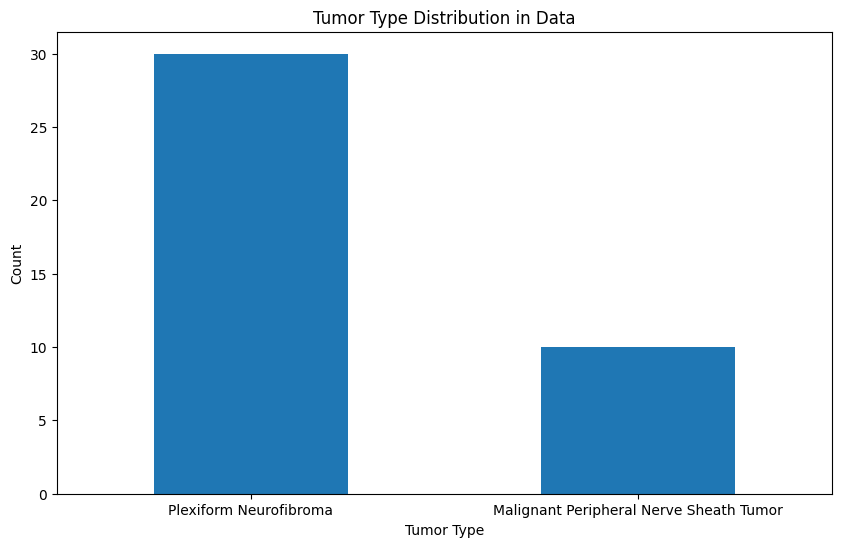

In [ ]:
tumor_counts = clinical['tumorType'].value_counts()
plt.figure(figsize=(10, 6))
tumor_counts.plot(kind='bar')
plt.title('Tumor Type Distribution in Data')
plt.xlabel('Tumor Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

#### Downloading files

Below, we download all the qualifying file result set and then show a snippet of what one of the files look like.

In [ ]:
file_accessions = results['id'].tolist()
files = [syn.get(acc) for acc in file_accessions]

In [ ]:
first_peek = files[1]
first_peek_content = pd.read_csv(first_peek.path, sep='\t')
first_peek_content

,Name,Length,EffectiveLength,TPM,NumReads
0,ENSG00000278625.1,106.00,10.752,0.0000,0.0
1,ENSG00000276017.1,2404.00,2203.880,0.0000,0.0
2,ENSG00000278573.1,603.00,403.244,0.0000,0.0
3,ENSG00000275757.1,153.00,25.441,88.2507,65.0
4,ENSG00000276312.1,90.00,8.369,0.0000,0.0
...,...,...,...,...,...
61593,ENSG00000258717.1,722.00,522.043,0.0000,0.0
61594,ENSG00000185559.16,1871.11,1671.020,40.8871,1978.0
61595,ENSG00000071246.11,1401.14,1201.110,110.7470,3851.0
61596,ENSG00000275161.1,204.00,50.983,0.0000,0.0


In [ ]:
# save file ids, local paths and specimenID for reference
ref = []

for file in files:
  ref.append((file.id, file.path, results.loc[results['id'] == file.id, 'specimenID'].values[0]))

ref_df = pd.DataFrame(ref, columns=['fileID', 'filePath', 'specimenID'])
ref_df.to_csv('local_data.csv', index=False)
ref_df


,fileID,filePath,specimenID
0,syn51538895,/root/.synapseCache/620/124909620/quant.genes.sf,JH-2-002-94FAA
1,syn51538907,/root/.synapseCache/632/124909632/quant.genes.sf,JH-2-023-876HC
2,syn51538984,/root/.synapseCache/711/124909711/quant.genes.sf,JH-2-031-BFF3F
3,syn51539631,/root/.synapseCache/365/124910365/quant.genes.sf,JH-2-061-1H66H
4,syn51539636,/root/.synapseCache/371/124910371/quant.genes.sf,JH-2-068-2BHHG
5,syn51539716,/root/.synapseCache/451/124910451/quant.genes.sf,JH-2-075-3HE68
6,syn51540151,/root/.synapseCache/890/124910890/quant.genes.sf,JH-2-002-FF824
7,syn51540157,/root/.synapseCache/896/124910896/quant.genes.sf,JH-2-001-8A1B1
8,syn51540166,/root/.synapseCache/904/124910904/quant.genes.sf,JH-2-002-GAF53
9,syn51540184,/root/.synapseCache/923/124910923/quant.genes.sf,JH-2-006-D6BA4


### Putting data files into correct input format

We need to wrangle these data files to achieve the correct input:
- A single matrix format with genes as rows and samples as columns.
- Gene name is Ensembl gene ids and package requires HUGO gene ids.

Note that this Python example will be more verbose compared to an R version, which can make use of convenience packages not available in Python.

##### Creating single matrix

Helpers to get a single matrix with rows as genes and columns for specimens.

In [ ]:
merged_df = pd.DataFrame()

for _, row in ref_df.iterrows():
    df = pd.read_csv(row['filePath'], sep="\t")
    # Need only 'Name' and 'TPM' columns
    df = df[['Name', 'TPM']]
    # 'TPM' values per specimenID
    df = df.rename(columns={'TPM': row['specimenID']})
    # Join on 'Name'
    if merged_df.empty:
        merged_df = df
    else:
        merged_df = pd.merge(merged_df, df, on='Name', how='outer')

merged_df

,Name,JH-2-002-94FAA,JH-2-023-876HC,JH-2-031-BFF3F,JH-2-061-1H66H,JH-2-068-2BHHG,JH-2-075-3HE68,JH-2-002-FF824,JH-2-001-8A1B1,JH-2-002-GAF53,...,JH-2-044-83F15,JH-2-085-F2983,JH-2-086-5EA11,JH-2-089-H8EBA,JH-2-091-CAA8H,JH-2-100-19H33,JH-2-094-5HA24,JH-2-104-51E2H,JH-2-107-AGD39,JH-2-111-G645D
0,ENSG00000278625.1,0.0000,0.0000,0.000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000
1,ENSG00000276017.1,0.0000,0.0000,0.000,0.0000,0.204158,0.100707,0.091722,0.0000,0.015553,...,0.32985,0.000000,0.075428,0.043396,0.000000,0.00000,0.00000,0.000000,0.000000,0.013052
2,ENSG00000278573.1,0.0000,0.0000,0.000,0.0000,0.101671,0.000000,0.000000,0.0000,0.799574,...,0.00000,0.000000,0.000000,0.257470,0.416913,0.00000,0.00000,0.120554,0.000000,0.000000
3,ENSG00000275757.1,255.3870,88.2507,314.342,0.0000,0.000000,330.663000,932.090000,650.4020,394.696000,...,0.00000,1075.690000,297.922000,1003.060000,1936.780000,1547.62000,999.12200,1185.670000,1609.620000,1336.660000
4,ENSG00000276312.1,0.0000,0.0000,0.000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61593,ENSG00000258717.1,0.0000,0.0000,0.000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000
61594,ENSG00000185559.16,447.1410,40.8871,275.791,10.4618,0.153036,0.211302,1.589830,11.1815,1575.090000,...,20.90500,0.623586,0.013662,0.283176,0.070925,2.92791,0.32543,0.544249,0.012186,0.000000
61595,ENSG00000071246.11,89.9011,110.7470,212.087,42.7916,96.038500,20.052000,39.661500,32.8313,12.265000,...,38.03850,13.780000,3.678180,32.926800,46.078300,30.74170,13.44830,40.043200,20.227600,16.464700
61596,ENSG00000275161.1,0.0000,0.0000,0.000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000


#### Mapping gene symbols

Now we just need to map Ensembl gene ids to HUGO ids. We'll use batch requests using the service https://docs.mygene.info/en/latest/doc/query_service.html#batch-queries-via-post.

In [ ]:
import requests

def chunk_list(lst, chunk_size):
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

def map_ensembl_to_hgnc(ensembl_ids):
    url = "https://mygene.info/v3/query"
    headers = {'Content-Type': 'application/json'}
    results = []
    for chunk in chunk_list(ensembl_ids, 3000):
        params = {
            'scopes': 'ensembl.gene',
            'fields': 'symbol',
            'species': 'human',
            'q': chunk
        }
        response = requests.post(url, headers=headers, json=params)
        if response.status_code == 200:
            results.extend(response.json())
        else:
            response.raise_for_status()
    return results

def remove_version(ensembl_id):
    return ensembl_id.split('.')[0]

ensembl_ids = df['Name'].apply(remove_version).tolist()

# Query MyGene.info API using POST batch service in chunks
mapping_results = map_ensembl_to_hgnc(ensembl_ids)

# Create a mapping dictionary
mapping_dict = {item['query']: item.get('symbol', None) for item in mapping_results}



In [ ]:
mapping_dict

{'ENSG00000278625': 'LOC124905334',
 'ENSG00000276017': None,
 'ENSG00000278573': None,
 'ENSG00000275757': 'LOC124907334',
 'ENSG00000276312': None,
 'ENSG00000278066': None,
 'ENSG00000278633': None,
 'ENSG00000273554': None,
 'ENSG00000278510': None,
 'ENSG00000274792': 'LOC102723532',
 'ENSG00000275249': None,
 'ENSG00000277927': 'LOC124905519',
 'ENSG00000276760': 'LOC102723502',
 'ENSG00000278673': None,
 'ENSG00000275063': 'LOC102723407',
 'ENSG00000276351': None,
 'ENSG00000275987': 'U1',
 'ENSG00000275405': 'LOC124905321',
 'ENSG00000278294': 'LOC124908250',
 'ENSG00000273730': 'LOC124907334',
 'ENSG00000274917': 'RNA5-8SN5',
 'ENSG00000276197': None,
 'ENSG00000278384': None,
 'ENSG00000274202': 'U2',
 'ENSG00000276932': 'Y_RNA',
 'ENSG00000274847': 'MAFIP',
 'ENSG00000210194': 'TRNE',
 'ENSG00000198695': 'ND6',
 'ENSG00000210191': 'TRNL2',
 'ENSG00000210176': 'TRNH',
 'ENSG00000198886': 'ND4',
 'ENSG00000212907': 'ND4L',
 'ENSG00000210174': 'TRNR',
 'ENSG00000198938': 'COX3'

In [ ]:
# Replace with mapped HGNC
merged_df['Name'] = merged_df['Name'].apply(lambda x: x.split('.')[0])
merged_df['Name'] = merged_df['Name'].map(mapping_dict)
# Rename 'Name' column to 'HUGO_Symbol'
merged_df.rename(columns={'Name': 'Hugo_Symbol'}, inplace=True)
# Remove rows where 'HUGO_Symbol' is None
merged_df = merged_df[merged_df['Hugo_Symbol'].notna()]

In [ ]:
# Create a dummy column with EntrezID because package expects it
merged_df.insert(0, 'Entrez_Gene_Id', None)
merged_df

[WARNING] <ipython-input-90-13974720230b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.rename(columns={'HUGO_Symbol': 'Hugo_Symbol'}, inplace=True)

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.rename(columns={'HUGO_Symbol': 'Hugo_Symbol'}, inplace=True)



ValueError: cannot insert Entrez_Gene_Id, already exists

### Running the analysis

We can run the analysis with suggested parameters. Write data and read back in.

In [ ]:
merged_df.to_csv("data.tsv", sep = "\t")
rna = td.read_rna_file("data.tsv", identifier="hugo")

sig = td.read_sig_file() # Use reference included with CIBERSORT
ciber_freqs = td.tumor_deconvolve(rna, 'cibersort',  patient_IDs='ALL', sig_matrix=sig, args={'nu':'best', 'scaling':'minmax'})


Running CiberSort...
CiberSort has completed!


### Interpretation of results

The output is a matrix of estimated immune cell fractions across 22 immune cell types.
Note that these are *not* "absolute" fractions of immune cells, but relative fractions.
The fractions are comparable across samples within the same dataset.


In [ ]:
ciber_freqs

Patient_ID,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,...,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils
Unnamed: 0,0.121465,0.000000,0.000000,0.088740,0.089552,0.217824,0.080910,0.000000,0.000000,0.010638,...,0.125920,0.000000,0.000000,0.000000,0.042726,0.000000,0.051794,0.000000,0.096261,0.000000
JH-2-002-94FAA,0.049418,0.000000,0.000000,0.170489,0.000000,0.000000,0.000000,0.079861,0.000000,0.000000,...,0.040310,0.249930,0.079519,0.223631,0.000000,0.000000,0.003163,0.000000,0.000000,0.000000
JH-2-023-876HC,0.005720,0.000000,0.000000,0.040744,0.000000,0.170334,0.000000,0.022139,0.000000,0.000000,...,0.072320,0.000000,0.001221,0.184625,0.000000,0.010397,0.000000,0.255956,0.007584,0.013418
JH-2-031-BFF3F,0.015345,0.000000,0.000000,0.043316,0.000000,0.086169,0.000000,0.007567,0.001914,0.000000,...,0.026142,0.487915,0.000000,0.188360,0.000000,0.049082,0.023732,0.005955,0.000000,0.000000
JH-2-061-1H66H,0.002142,0.076887,0.000000,0.052813,0.000000,0.095997,0.000000,0.012870,0.003700,0.000000,...,0.085976,0.000000,0.025568,0.253941,0.003125,0.000000,0.171349,0.000000,0.000000,0.000000
JH-2-068-2BHHG,0.003327,0.006560,0.000000,0.046214,0.000000,0.013950,0.000000,0.041390,0.000000,0.000000,...,0.046572,0.000000,0.000000,0.256048,0.000000,0.012486,0.000000,0.477792,0.014055,0.008866
JH-2-075-3HE68,0.004106,0.008426,0.000000,0.000000,0.000000,0.316360,0.000000,0.076792,0.034323,0.000000,...,0.114325,0.005389,0.002263,0.034146,0.008804,0.000000,0.186120,0.000000,0.000000,0.000000
JH-2-002-FF824,0.028384,0.000000,0.000765,0.030931,0.000000,0.067894,0.000000,0.014078,0.000000,0.000000,...,0.246391,0.000000,0.042674,0.512406,0.000000,0.000000,0.000000,0.011241,0.000000,0.000000
JH-2-001-8A1B1,0.000000,0.003274,0.000000,0.044618,0.000000,0.077088,0.000000,0.009796,0.004285,0.001756,...,0.242281,0.000000,0.013623,0.395869,0.000000,0.000000,0.005856,0.140452,0.000000,0.000000
JH-2-002-GAF53,0.000000,0.000000,0.004084,0.181563,0.000000,0.123654,0.012003,0.052759,0.001267,0.042956,...,0.000000,0.000000,0.189184,0.342883,0.000000,0.000000,0.000000,0.000000,0.000000,0.034536


### Visualization of results

A better way to understand the output is to visualize it. The package comes with default plots, but we will show customizing the plots since this is one of the advantages of analyzing data in a flexible manner.

#### Default plots

Show cell type fractions with package-provided plotting. This doesn't show any groupings by tumor type. But the cell fractions look pretty reasonable... Tumor-associated macrophages and their precursors make up the largest fraction of the myeloid infiltrate in the majority of human solid tumors [(Vitale et al. 2019)](https://doi.org/10.1016/j.cmet.2019.06.001).



[WARNING] /usr/local/lib/python3.10/dist-packages/TumorDecon/visualization.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Patient_ID", y="value",order=sorted_cells, data=pd.melt(new_cell_freq),palette=palette)


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Patient_ID", y="value",order=sorted_cells, data=pd.melt(new_cell_freq),palette=palette)



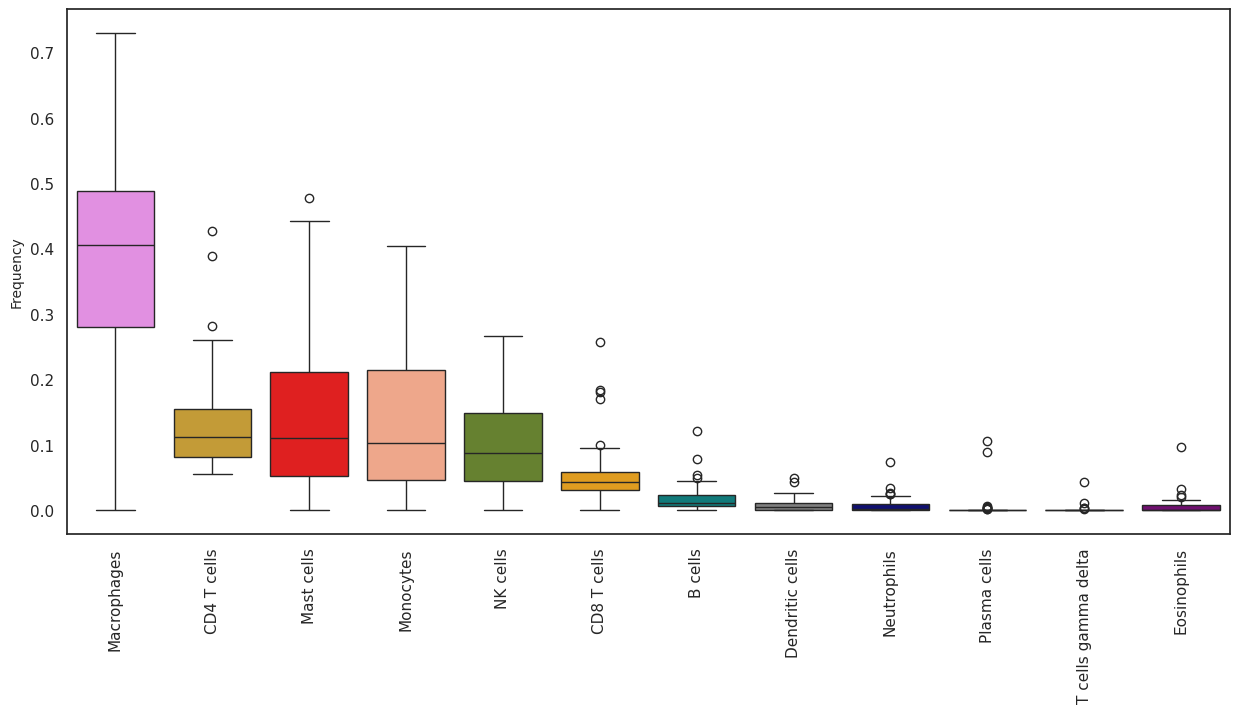

In [ ]:
td.cell_frequency_boxplot(ciber_freqs)

## Summary

We showed how to work with datasets and do basic analysis primarily with Python (though R also works in Colab, just not as natively). The Python package we used offers four inference approaches, of which we tried CIBERSORT. However, the primary purpose was understand data/metadata organization and obtaining data rather than benchmarking or getting into deep analysis.

## Related resources

R equivalents to try:
- [immunedeconv](https://github.com/omnideconv/immunedeconv)
- [IOBR](https://github.com/IOBR/IOBR/).

Blogs to read:
* https://autobencoder.com/2021-10-03-gene-conversion/




